# Heart Disease Prediction

Following a current trend in clinical diagnosis, where machine learning is applied to medical data in order to predict health conditions, this notebook shows a first approach to solving such problem.

The notebook is divided into two main sections:
1. Medical context and data summary
2. Data characterization
    * Data visualization
3. Classification models
    * Random Forest
    * Support Vector Machine (SVM)
    * Multilayer Perceptron (MLP)

At the end, a summary and conclusion is presented.

Dataset was extracted from https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive on February 21st, 2021.

## Medical Context and Data Summary

The data used contains clinical information regarding a series of patients, namely:
* Age
* Sex
* Type of chest pain
* Resting blood pressure
* Serum cholesterol
* Fasting blood sugar
* Electrocardiogram (ECG) results
* Heart rate
* Presence of heart disease

What some of these mean is already known to us - age, sex, heart rate, presence of heart disease, blood pressure, cholesterol, blood sugar - the remaining ones are described below.

### Type of Chest Pain

Chest pains in this data set are described as one of the following four categories:
1. Typical angina
2. Atypical angina
3. Non-anginal pain
4. Asymptomatic (i.e. no pain)

As such to comprehend the categories, we need to define angina [1]:

> **Angina:**  
_Chest pain caused by reduced blood flow to the heart muscles._

This can be further differentiated in _typical_ and _atypical_ anginas:

> **Typical angina:**  
_Episodes with a trigier (such as stress or exercisce) that stop within a few minutes of resting._  
**Atypical angina:**  
_Episodes may not have a trigger and can continue despite resting._

### Electrocardiogram segments

Some of the features in the data relate to specific information in ECG results, a schematic of such is seen in Fig. 1.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/SinusRhythmLabels.svg/1024px-SinusRhythmLabels.svg.png" width="400">
<center>Fig. 1 - Schematic of a regular ECG</center>

Information on the dataset pertains to ST-T wave abnormalities, Estes' criteria, slope of the ST segment and the ST depression induced by exercise relative to rest [2]. Definitions relevant to the dataset used are described below.

> **De/Repolarization:**  
_Changes in the polarization of the cell's membrane potential._  

> **ST Segment:**  
_Represents the period when the ventricles are depolarized._  
> **T Wave:**  
_Represents repolarization of the ventricles._  

> **Estes' Criteria:**  
_Set of criteria to determine the probability of Left Ventricular Hypertrophy._  


### Problem Statement

With all the data available, the question if there is any underlying pattern concerning heart diseases and if it can be used for predictions rises. This problem has been tackled before in literature [3, 4]. Here a first approach to answering that question is presented. For this, three different machine learning models are attempted:
* Random Forest
* SVM (linear, polynomial, RBF and sigmoid kernels)
* Multilayer Perceptron

## Data Characterization and Visualization

In this section, exploration of the dataset is presented with accompanying visualizations and (when appliable) statistical metrics. A sample of the dataset is shown below.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, f1_score, plot_confusion_matrix

In [2]:
filename = "heart_statlog_cleveland_hungary_final.csv"
df = pd.read_csv(filename)
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [3]:
df.dtypes

age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object

Following the documentation provided with the dataset:

Numerical attributes (units between square brackets):  
* age \[year\]  
* resting bp s (resting blood pressure) \[mm Hg\]  
* cholesterol (serum cholesterol) \[mg/dL\]
* max heart rate (maximum heart rate achieved) \[bpm\]
* oldpeak (ST depression) - units not given

Categorical attributes:
* sex  
    0 = Female  
    1 = Male  
* chest pain type  
    1 = Typical angina  
    2 = Atypical angina  
    3 = Non-anginal pain  
    4 = Asymptomatic
* fasting blood sugar  
    0 = Fasting blood sugar < 120 mg/dL  
    1 = Fasting blood sugar > 120 mg/dL
* resting ecg  
    0 = Normal  
    1 = ST-T wave abnormality  
    2 = Probable/Definite left ventricular hypertrophy by Estes' criteria
* exercise angina  
    0 = No exercise induced angina  
    1 = Exercise induced agina
* ST slope  
    1 = Positive slope  
    2 = Flat  
    3 = Negative slope
* class  
    0 = No heart disease  
    1 = Heart disease
    
For the numerical categories, a table with common univariate statistical metrics is shown below.

In [4]:
numerical_df = df[["age", "resting bp s", "cholesterol", "max heart rate", "oldpeak"]]
numerical_df.describe()

,age,resting bp s,cholesterol,max heart rate,oldpeak
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,132.153782,210.363866,139.732773,0.922773
std,9.358203,18.368823,101.420489,25.517636,1.086337
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,188.000000,121.000000,0.000000
50%,54.000000,130.000000,229.000000,140.500000,0.600000
75%,60.000000,140.000000,269.750000,160.000000,1.600000
max,77.000000,200.000000,603.000000,202.000000,6.200000


### Visualizing the Data

To better understand the contents of the data used, plotting it can be more useful than simply showing a table. 

In [5]:
color_bar = "#D7E8FF"
colors_class = ["#D7E8FF", "#EF2D1B"]
colors_gender = ["#F5BCFA", "#AEEAF5"]
colors_fbs = ["#ff0000", "#00ff00"]

In [6]:
def get_col_value_counts(pandaSeries, category_dict):
    count = pandaSeries.value_counts(sort=False)

    for cat_key in category_dict.keys():
        count[category_dict[cat_key]] = count.pop(cat_key)

    values = [v for v in count]
    labels = count.keys()
    return values, labels

In [7]:
def build_barh(pandasSeries, catDict, title=""):

      
    values, labels = get_col_value_counts(pandasSeries, catDict)
   
    ymin = min(catDict.keys())

    ymax=max(catDict.keys())+1
    y_coord = range(ymin,ymax)
    plt.title(title)
    plt.barh(y=y_coord, width=values, tick_label=labels, color = color_bar)
    plt.box(False)
    for i, v in enumerate(values):
        if ymin == 0:
            plt.text(v+3, i, str(v))
        else:
            plt.text(v+3, i+1, str(v))

In [8]:
def build_pie(pandaSeries, catDict, title="", colors=colors_class,labels=True):
    values, labels_count = get_col_value_counts(pandaSeries, catDict)

    if labels == False:
        labels_count = None
    
    plt.pie(values,labels=labels_count,autopct='%1.1f%%', colors=colors)
    plt.title(title)
    plt.axis('equal')

In [9]:
def build_hist(pandaSeries, title=""):
    n, bins, patches = plt.hist(pandaSeries, rwidth=0.9, color = color_bar)
    plt.box(False)
    plt.title(title)
    for k in range(0, len(n)):
        v = n[k]
        i = bins[k]
        plt.text(i, v+3, str(v))
    #plt.tick_params(axis="y", left=False, labelleft=False)

#### class

The attribute used to distinguish if an individual has or not a heart disease. As seen below, 47% of the subjects show no heart disease, while 53% do.

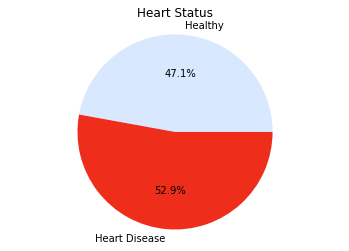

In [10]:
category_dict = {0: "Healthy", 
                 1: "Heart Disease"}
build_pie(df["target"], category_dict, title="Heart Status")
plt.show()

#### sex

The dataset is not so balanced when it comes to subjects' gender. Only 24% concern female individuals. 

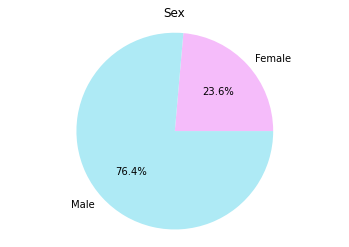

In [11]:
gender_dict = {0: "Female", 
                 1: "Male"}

build_pie(df["sex"], gender_dict, title="Sex", colors=colors_gender)

plt.show()

As a simple exercise to see if any of the attributes can have an influence on the _class_ value, the data was divided according to gender. The plots below show that (for this dataset) male subjects show a higher tendency to develop heart diseases when compared to the females. 

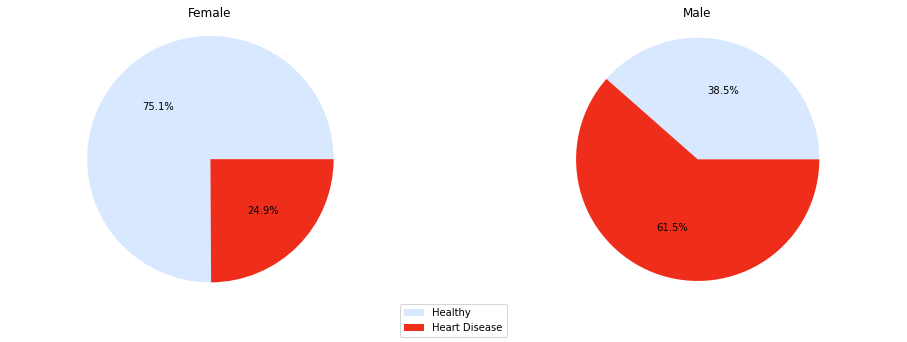

In [12]:
female_df = df[df["sex"] == 0]
male_df = df[df["sex"] == 1]

_, labels = get_col_value_counts(female_df["target"], category_dict)

fig = plt.figure(figsize=(16, 5))

plt.subplot(1,2,1)
build_pie(female_df["target"], category_dict, title="Female", labels=False)

plt.subplot(1,2,2)
build_pie(male_df["target"], category_dict, title="Male", labels=False)

fig.legend(labels=labels, loc=8)

plt.show()

#### chest pain type

Below is a bar chart showing the count and proportion for each type of chest pain described.

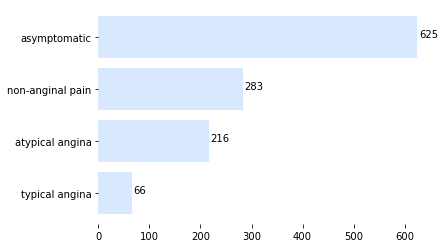

In [13]:
pain_dict = {1: "typical angina",
             2: "atypical angina",
             3: "non-anginal pain",
             4: "asymptomatic"}

build_barh(df["chest pain type"], pain_dict)

plt.show()

#### resting ecg

Below is a bar chart showing the count and proportion for each type of resting ECG described.

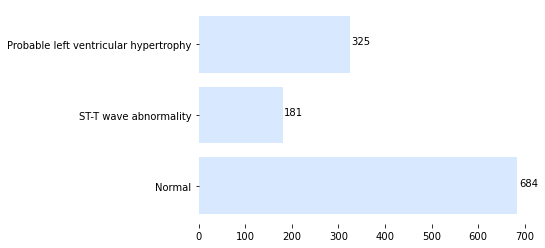

In [14]:
ecg_dict = {0: "Normal",
            1: "ST-T wave abnormality",
            2: "Probable left ventricular hypertrophy"}

build_barh(df["resting ecg"], ecg_dict)

plt.show()

#### age, resting bp s, max heart rate, cholesterol

Histograms for the attributes mentioned above are shown below with the respective count for each bin's class on top of the respective bar.

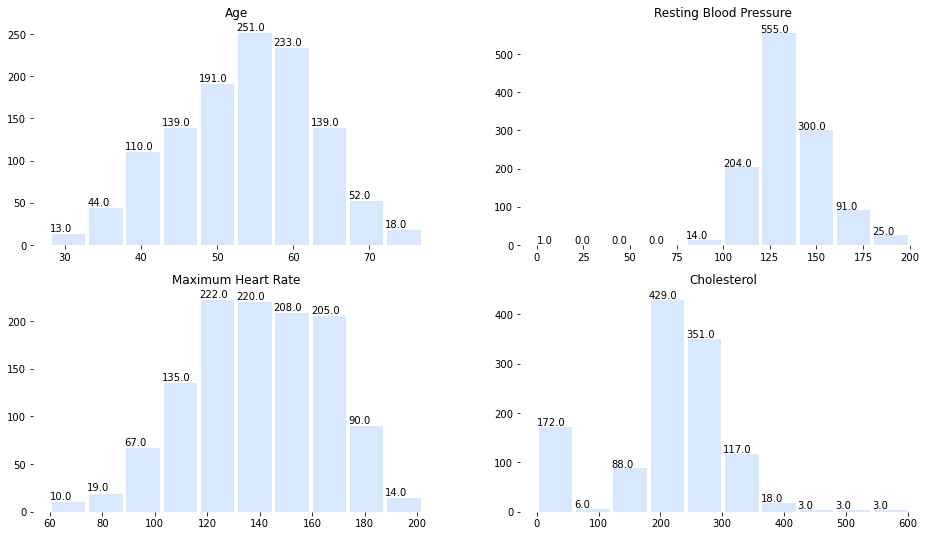

In [15]:
plt.figure(figsize=(16,9))

plt.subplot(221)
build_hist(df["age"], title="Age")

plt.subplot(222)
build_hist(df["resting bp s"], title="Resting Blood Pressure")

plt.subplot(223)
build_hist(df["max heart rate"], title="Maximum Heart Rate")

plt.subplot(224)
build_hist(df["cholesterol"], title="Cholesterol")

plt.show()

#### fasting blood sugar, exercise angina

Two pie charts below show the proportion of values in the binary attributes _fasting blood sugar_ and _exercise angina_.

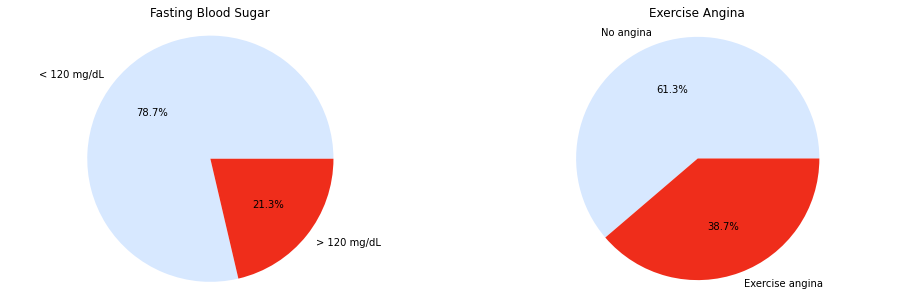

In [16]:
plt.figure(figsize=(16,5))

sugar_dict = {0: "< 120 mg/dL", 
                 1: "> 120 mg/dL"}
plt.subplot(121)
build_pie(df["fasting blood sugar"], sugar_dict, title="Fasting Blood Sugar")

exercise_dict = {0: "No angina", 
                 1: "Exercise angina"}
plt.subplot(122)
build_pie(df["exercise angina"], exercise_dict, title="Exercise Angina")

plt.show()

#### ST slope, oldpeak

The remaining two attributes pertain to the ST segment of the ECG. A horizonal bar graph, below on the left, shows the count for each of _ST slope_ possible values. As seen, there is one single record with a value not mentioned in the documentation and as such is simply described as "NA. The histogram on the right concerns _oldpeak_.

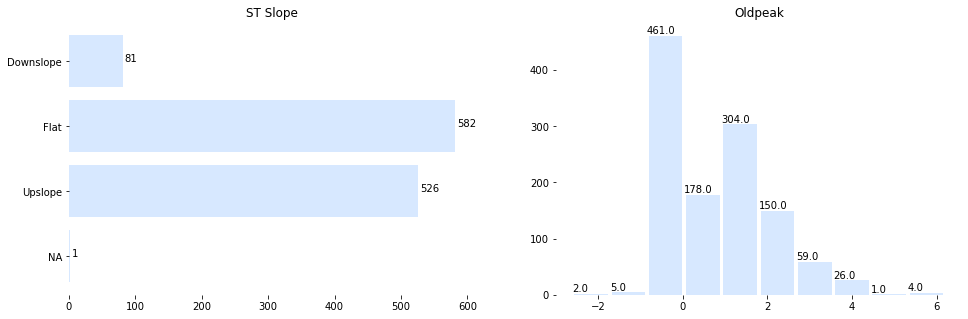

In [17]:
plt.figure(figsize=(16,5))

slope_dict = {0: "NA",
                1: "Upslope",
                2: "Flat",
                3: "Downslope"}

plt.subplot(121)
build_barh(df["ST slope"], slope_dict, title="ST Slope")

plt.subplot(122)
build_hist(df["oldpeak"], title="Oldpeak")

plt.show()

## Classification models

As previously stated, three different classification models will be attempted in order to predict heart disease by using the given data. All models were implemented using the library `sklearn`.

### Preparing data

Before training any model, the dataset needs to be prepared. In this case this consists in performing one-hot-encoding on the non-binary categorical attributes. In this way, if a category for a given attribute is labeled, for example, as 4, it will not have a greater influence than the category labeled as 1. Since normalization of numerical attributes might affect the outcome of both SVM and MLP, data will also be normalized following a min-max procedure.

In [18]:
def min_max_norm(pandasSeries):
    min_value = pandasSeries.min()
    max_value = pandasSeries.max()
    delta = max_value-min_value
    return (pandasSeries-min_value)/delta

In [19]:
display(df.head())

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [20]:
features = df.drop("target", axis=1)

features["sex"].replace(gender_dict, inplace=True)
features["chest pain type"].replace(pain_dict, inplace=True)
features["fasting blood sugar"].replace(sugar_dict, inplace=True)
features["resting ecg"].replace(ecg_dict, inplace=True)
features["exercise angina"].replace(exercise_dict, inplace=True)
features["ST slope"].replace(slope_dict, inplace=True)

features["age"] = min_max_norm(features["age"])
features["resting bp s"] = min_max_norm(features["resting bp s"])
features["cholesterol"] = min_max_norm(features["cholesterol"])
features["max heart rate"] = min_max_norm(features["max heart rate"])
features["oldpeak"] = min_max_norm(features["oldpeak"])

display(features.head())

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,0.244898,Male,atypical angina,0.70,0.479270,< 120 mg/dL,Normal,0.788732,No angina,0.295455,Upslope
1,0.428571,Female,non-anginal pain,0.80,0.298507,< 120 mg/dL,Normal,0.676056,No angina,0.409091,Flat
2,0.183673,Male,atypical angina,0.65,0.469320,< 120 mg/dL,ST-T wave abnormality,0.267606,No angina,0.295455,Upslope
3,0.408163,Female,asymptomatic,0.69,0.354892,< 120 mg/dL,Normal,0.338028,Exercise angina,0.465909,Flat
4,0.530612,Male,non-anginal pain,0.75,0.323383,< 120 mg/dL,Normal,0.436620,No angina,0.295455,Upslope


In [21]:
features = pd.get_dummies(features)

features.head()

,age,resting bp s,cholesterol,max heart rate,oldpeak,sex_Female,sex_Male,chest pain type_asymptomatic,chest pain type_atypical angina,chest pain type_non-anginal pain,...,fasting blood sugar_> 120 mg/dL,resting ecg_Normal,resting ecg_Probable left ventricular hypertrophy,resting ecg_ST-T wave abnormality,exercise angina_Exercise angina,exercise angina_No angina,ST slope_Downslope,ST slope_Flat,ST slope_NA,ST slope_Upslope
0,0.244898,0.70,0.479270,0.788732,0.295455,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,0.428571,0.80,0.298507,0.676056,0.409091,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
2,0.183673,0.65,0.469320,0.267606,0.295455,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1
3,0.408163,0.69,0.354892,0.338028,0.465909,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.530612,0.75,0.323383,0.436620,0.295455,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [22]:
targets = np.array(df["target"])
feature_list = list(features.columns)
features = np.array(features)

After both normalization and one-hot-encoding of the dataset, we split into a training and a test subsets.

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size=0.3)

### Random Forest

The first model tested is the Random Forest, composed of 100 decision trees.

Average precision: 93.86%
Maximum F1-score is 0.94 at a threshold level of 0.50


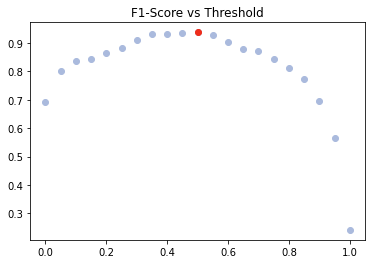

In [24]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_features, train_labels)

score = rf.predict(test_features)
ap = average_precision_score(test_labels, score)
ap = ap*100
print("Average precision: %0.2f%%" % ap)

threshold = []
f1 = []
for t in range(0, 105, 5):
    results = [1 if s >= (t/100) else 0 for s in score]
    threshold.append(t/100)
    f1.append(f1_score(test_labels, results))
    
opt_threshold = threshold[f1.index(max(f1))]
print("Maximum F1-score is %0.2f at a threshold level of %0.2f" % (max(f1), opt_threshold))

plt.scatter(threshold, f1, color="#AABADD")
plt.scatter(opt_threshold, max(f1), color=colors_class[1])
plt.title("F1-Score vs Threshold")
plt.show()

### SVM

Aftewards, a SVM model is implemented. From the available kernels, the choice seems to be between the polynomial of third degree (default value of the function used) and RBF. For further comparison between models, these two kernels will be used.

In [25]:
kernel_list = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernel_list:
    svm_clf = svm.SVC(kernel=kernel)
    svm_clf.fit(train_features, train_labels)
    pred = svm_clf.predict(test_features)
    print("Using %s kernel,\n\tF1-score: %0.2f" % (kernel,f1_score(test_labels, pred)))

    ap = average_precision_score(test_labels, pred)
    ap = ap*100
    print("\tAverage precision: %0.2f%%" % ap)

Using linear kernel,
	F1-score: 0.85
	Average precision: 80.17%
Using poly kernel,
	F1-score: 0.84
	Average precision: 80.38%
Using rbf kernel,
	F1-score: 0.85
	Average precision: 80.32%
Using sigmoid kernel,
	F1-score: 0.78
	Average precision: 73.79%


### MLP

Using a simple multilayer perceptron neural network it also seems possible to predict heart disease with the given data.

In [26]:
mlp_clf = MLPClassifier(solver="sgd",  hidden_layer_sizes=(100,), max_iter=1000)
mlp_clf.fit(train_features, train_labels)
mlp_pred = mlp_clf.predict(test_features)

print("F1-score: %0.2f" % f1_score(test_labels, mlp_pred))

F1-score: 0.85


### Model Comparison

After verifying that the proposed models seem to accuratelly predict heart diseases, they can now be compared. For this, the metric used will be the F1-Score. Since the goal is to compare general model type, an average score will be calculated from several model fitting and prediction loops, each with a different training and testing sets.

In [27]:
def prediction_models_f1(train_features, test_features, train_labels, test_labels):
    
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(train_features, train_labels)
    score = rf.predict(test_features)
    f1 = []
    for t in range(0, 105, 5):
        results = [1 if s >= (t/100) else 0 for s in score]
        f1.append(f1_score(test_labels, results))
    rf_f1 = max(f1)
    
    poly_svm = svm.SVC(kernel="poly")
    poly_svm.fit(train_features, train_labels)
    poly_pred = poly_svm.predict(test_features)
    poly_svm_f1 = f1_score(test_labels, poly_pred)
    
    rbf_svm = svm.SVC(kernel="rbf")
    rbf_svm.fit(train_features, train_labels)
    rbf_pred = rbf_svm.predict(test_features)
    rbf_svm_f1 = f1_score(test_labels, rbf_pred)
    
    mlp_clf = MLPClassifier(solver="sgd",  hidden_layer_sizes=(100,), max_iter=1000)
    mlp_clf.fit(train_features, train_labels)
    mlp_pred = mlp_clf.predict(test_features)
    mlp_f1 = f1_score(test_labels, mlp_pred)

    return rf_f1, poly_svm_f1, rbf_svm_f1, mlp_f1    

In [28]:
max_cycles = 50

rf_list = []
poly_svm_list = []
rbf_svm_list = []
mlp_list = []

for k in range(0, max_cycles):
    train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size=0.3)
    rf_f1, p_svm_f1, rbf_svm_f1, mlp_f1 = prediction_models_f1(train_features, test_features, train_labels, test_labels)
    rf_list.append(rf_f1)
    poly_svm_list.append(p_svm_f1)
    rbf_svm_list.append(rbf_svm_f1)
    mlp_list.append(mlp_f1)
    
print("Average F1-Score")
print("\tRandom Forest: %0.2f" % (sum(rf_list)/len(rf_list)))
print("\tSVM with polynomial kernel: %0.2f" % (sum(poly_svm_list)/len(poly_svm_list)))
print("\tSVM with RBF kernel: %0.2f" % (sum(rbf_svm_list)/len(rbf_svm_list)))
print("\tMultilayer Perceptron: %0.2f" % (sum(mlp_list)/len(mlp_list)))

Average F1-Score
	Random Forest: 0.92
	SVM with polynomial kernel: 0.86
	SVM with RBF kernel: 0.86
	Multilayer Perceptron: 0.85


From the above tests we can infer that it seems possible to predict heart disease given several attributes concerning an individual's health. Of the models studied, a random forest is the one with the highest F1-Score and as such should prioritized in further studies with similar datasets.

## References

[1] https://www.nhs.uk/conditions/angina/  
[2] https://archive.ics.uci.edu/ml/datasets/heart%2BDisease  
[3] S. Benbelkacem and B. Atmani, "Random Forests for Diabetes Diagnosis," _2019 International Conference on Computer and Information Sciences (ICCIS)_, Sakaka, Saudi Arabia, 2019, pp. 1-4, doi: 10.1109/ICCISci.2019.8716405  
[4] Birjais, R., Mourya, A.K., Chauhan, R. _et al._ Prediction and diagnosis of future diabetes risk: a machine learning approach. _SN Appl. Sci._ 1, 1112 (2019). https://doi.org/10.1007/s42452-019-1117-9  